<a href="https://colab.research.google.com/github/jackaleksa/DL-Jack-Aleksa/blob/main/AIT_09_Author_classification_assessment%2C_Jack_Aleksa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2021 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it. 

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from urllib.request import urlretrieve
import numpy as np
import random
import sys
import re, cgi
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Dropout

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python. 

In [3]:
url_book="https://www.gutenberg.org/cache/epub/45/pg45.txt"
urlretrieve(url_book, 'book0.txt')
text0 = open("book0.txt", encoding='utf-8').read().lower()
count0 = Counter(text0)

url_book="http://www.gutenberg.org/files/2151/2151-0.txt"
urlretrieve(url_book, 'book1.txt')
text1 = open("book1.txt", encoding='utf-8').read().lower()
count1 = Counter(text1)

## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

Unique characters of the book Anne of Green Gables: 580100
Unique characters of the book The Works of Edgar Allan Poe, Volume 5: 486583


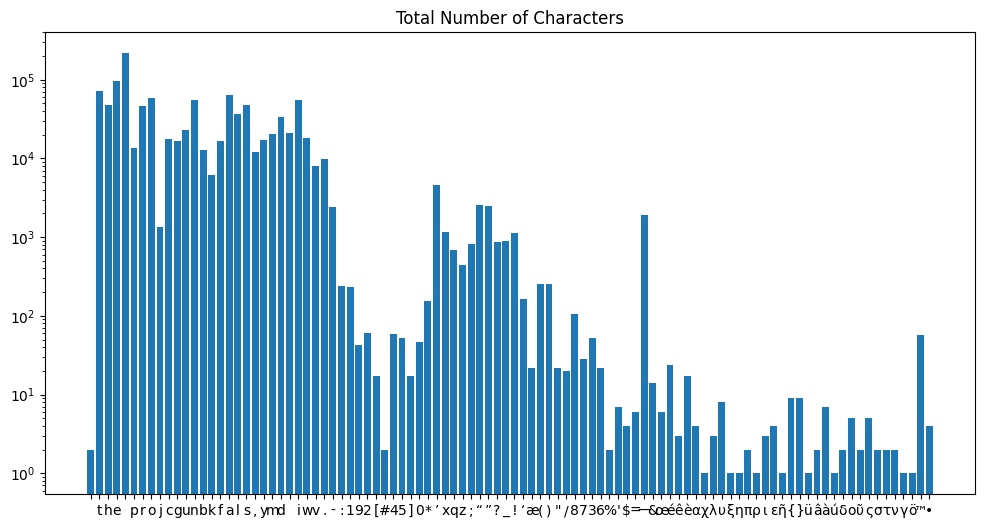

In [4]:
print('Unique characters of the book Anne of Green Gables:', len(text0))
print('Unique characters of the book The Works of Edgar Allan Poe, Volume 5:', len(text1))

text = text0 + text1
count = Counter(text)

plt.figure(figsize=(12,6))
plt.yscale('log')
plt.bar(count.keys(), count.values())
plt.title('Total Number of Characters')
plt.show()

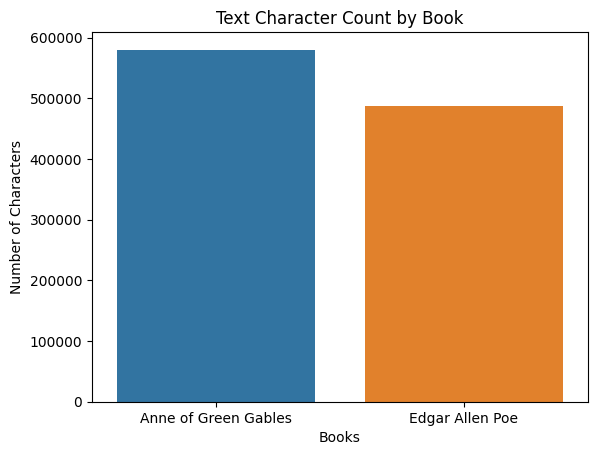

In [5]:
num_chars0 = len(text0)
num_chars1 = len(text1)

# Display results on Seaborn countplot
authors = ['Anne of Green Gables', 'Edgar Allen Poe']
char_counts = [num_chars0, num_chars1]

sns.barplot(x=authors, y=char_counts)
plt.ylabel('Number of Characters')
plt.xlabel('Books')
plt.title('Text Character Count by Book')
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author. 

Later you may change sequence_length to achieve better results!

In [6]:
unique_chars = sorted(list(set(text0+text1)))

char_indices = dict((c, i) for i, c in enumerate(unique_chars))
indices_char = dict((i, c) for i, c in enumerate(unique_chars))

maxlen  = 60
step    = 10   # the step size between two "sentence" is 10 characters

sentences0  = [] # maxlen number of characters, with "step" overlap between two "sentences" 
sentences1  = [] # maxlen number of characters, with "step" overlap between two "sentences" 

for i in range(0, len(text0)-maxlen, step):
    sentences0.append(text0[i:i+maxlen])

for i in range(0, len(text1)-maxlen, step):
    sentences1.append(text1[i:i+maxlen])

X = np.zeros((len(sentences0 + sentences1), maxlen, len(unique_chars)))
Y = np.zeros((len(sentences0 + sentences1), 2))

for i, sentence in enumerate(sentences0):
    for t, char in enumerate(sentence): 
        X[i,t,char_indices[char]] = 1
    Y[i,0] = 1

for i, sentence in enumerate(sentences1):
    for t, char in enumerate(sentence): 
        X[i + len(sentences0),t,char_indices[char]] = 1
    Y[i + len(sentences0),1] = 1

indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

print ("Shape of the input data:", X.shape)
print ("Shape of the target data:", Y.shape)

Shape of the input data: (106657, 60, 98)
Shape of the target data: (106657, 2)


## Data splitting
Split the data into train, validate and test sets. Make 

In [7]:
train_ratio  = 0.8
train_length = X.shape[0]
train_split  = int(train_ratio*train_length)
X_test, Y_test = X[train_split:], Y[train_split:]
X_train, Y_train = X[:train_split], Y[:train_split] 

valid_ratio  = 0.75
valid_length = X_train.shape[0]
valid_split  = int(valid_ratio*valid_length)
X_valid, Y_valid = X_train[valid_split:], Y_train[valid_split:]
X_train, Y_train = X_train[:valid_split], Y_train[:valid_split]
print(Y_test[:,0].sum())

11735.0


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [8]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(Y_train.shape[1], activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 128)           37760     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 128)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 13, 128)           0

## Model training
Train the model and apply early stopping.

In [10]:
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer= optimizer)

es = EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss")

model.fit(X_train, Y_train, 
          validation_data = (X_valid,Y_valid),
          epochs=20, batch_size=128, 
          callbacks=[es],
          verbose=2)

Epoch 1/20
500/500 - 45s - loss: 0.2486 - val_loss: 0.1376 - 45s/epoch - 89ms/step
Epoch 2/20
500/500 - 43s - loss: 0.1652 - val_loss: 0.1410 - 43s/epoch - 85ms/step
Epoch 3/20
500/500 - 41s - loss: 0.1552 - val_loss: 0.2254 - 41s/epoch - 82ms/step
Epoch 4/20
500/500 - 42s - loss: 0.1544 - val_loss: 0.1228 - 42s/epoch - 84ms/step
Epoch 5/20
500/500 - 41s - loss: 0.1554 - val_loss: 0.1755 - 41s/epoch - 82ms/step
Epoch 6/20
500/500 - 41s - loss: 0.1504 - val_loss: 0.1260 - 41s/epoch - 82ms/step
Epoch 7/20
500/500 - 41s - loss: 0.1516 - val_loss: 0.1235 - 41s/epoch - 82ms/step


## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [11]:
eval = model.evaluate(X_test,Y_test)
print("Test loss:",eval)
#print("Test accuracy:",eval[1])

667/667 [==============================] - 5s 7ms/step - loss: 0.1157
Test loss: 0.11571844667196274


## Confusion matrix
Calculate and display the confusion matrix.

667/667 [==============================] - 5s 8ms/step


<Axes: >

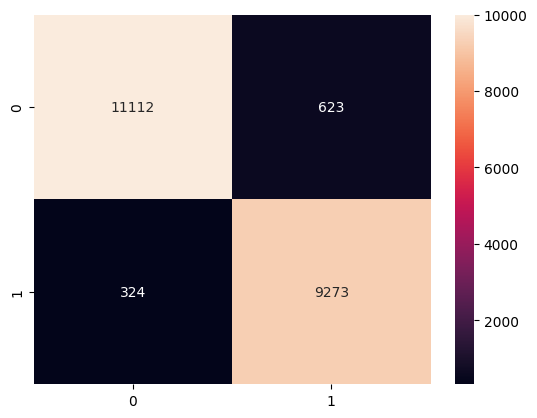

In [12]:
preds=model.predict(X_test)
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=10000)